# Root fit analyzing neural network


By Brady Lowe

lowebra2@isu.edu

7/25/2018


This Jupyter notebook was written to both develope and explain how we can use
neural networks to analyze the output of root fits to raw data.

#### Load necessary packages

In [1]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json

# Some items for plotting and drawing
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt

# Need numpy
import numpy as np
import nn_utils as utils

%matplotlib inline

Using TensorFlow backend.


#### Load root fit data from file

In [2]:
# Load dataset
x, y = utils.load_dataset_mysql(im_dir="train", log=True)
x_dev, y_dev = utils.load_dataset_mysql(im_dir="dev", log=True)

# Grab dimensions of picture
(m, h, w, c) = x.shape
m_dev = x_dev.shape[0]
input_shape = h, w, c

# Print dimensions
print("(m, height, width, channels): (" + str(m) + ", " + str(h) + ", " + str(w) + ", " + str(c) + ")")
print("m_dev: " + str(m_dev))


(m, height, width, channels): (2714, 236, 348, 3)
m_dev: 350


label: good
label: [1]


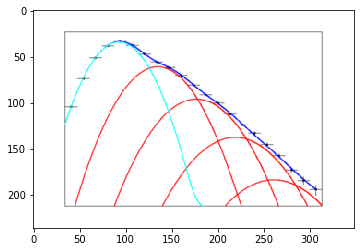

In [3]:
# Print an image
index = 777
this_image = x[index]
if y[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(y[index]))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

## Define and Train 3 layer ConvNet with 2 fully connected layers plus output layer

For the convolutional layer, we will scan over our images with a certain stride and a certain kernal size. 
Each individual scan represents a single neuron in the next layer. Since each scan connects to kernal size squared
neurons below it, convolutions reduce the number of degrees of freedom. Hopefully, through learning the right filters,
we can preserve the important information as we reduce it in size.

Once the image has gone through the convolutional layers (and therefore has been reduced to its features vector), we
can send the resulting vector into some old-fashioned fully-connected layers, and finally into a logistic regression unit.

##### Define hyperparameters

In [4]:
# Initialize
filters = []
kernels = []
strides = []
pools = []
dropouts = []

# Conv1
filters.append(16)
kernels.append(5)
strides.append(2)
pools.append(2)
dropouts.append(0.4)

# Conv2
filters.append(64)
kernels.append(5)
strides.append(2)
pools.append(2)
dropouts.append(0.4)

# Conv3
filters.append(256)
kernels.append(3)
strides.append(2)
pools.append(2)
dropouts.append(0.2)

# Conv4
filters.append(1024)
kernels.append(3)
strides.append(1)
pools.append(1)
dropouts.append(0.2)

# Define dense (fully-connected) layer sizes
fc1 = 30
fc2 = 30

##### Define keras layers (model)

In [5]:
# Define input layer (RGB image matrix)
X = Input(shape=input_shape, name='Input')

# Initialize activation as input
a = X
# Loop through all convolutional layers
for i in range(len(filters)):
    # Perform convolution
    a = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv' + str(i)))(a)
    # Normalize
    a = BatchNormalization(axis=3, name=('bn' + str(i)))(a)
    # Activate
    a = Activation('relu', name=('a' + str(i)))(a)
    # Max-pool
    a = MaxPooling2D((pools[i], pools[i]), name=('max_pool' + str(i)))(a)
    # Dropout
    a = Dropout(rate=dropouts[i])(a)

# Flatten output of convNet
a = Flatten()(a)
# Define first fully connected layer
a = Dense(units=fc1, activation='relu', name='fc0')(a)
# Use some dropout here for regularization
a = Dropout(rate=0.2)(a)
# Define second fully connected layer
a = Dense(units=fc2, activation='relu', name='fc1')(a)
# Define output layer 
a = Dense(units=1, activation='sigmoid', name='sigmoid')(a)

# Make the model
model = Model(inputs=X, outputs=a)

##### Define optimizer, loss, and metrics. Compile model.

In [10]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']
# Compile model
model.compile(loss=loss, optimizer='sgd', metrics=metrics)
# Print summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 236, 348, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 58, 86, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 58, 86, 32)        128       
_________________________________________________________________
a0 (Activation)              (None, 58, 86, 32)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 29, 43, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 29, 43, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 9, 13, 128)        102528    
__________

##### Fit the model to the data (train)

Train on 2714 samples, validate on 350 samples
Epoch 1/2000
2714/2714 [==============================] - 11s 4ms/step - loss: 0.0833 - acc: 0.9031 - val_loss: 0.0467 - val_acc: 0.9457
Epoch 2/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0464 - acc: 0.9418 - val_loss: 0.0360 - val_acc: 0.9571
Epoch 3/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0389 - acc: 0.9514 - val_loss: 0.0334 - val_acc: 0.9629
Epoch 4/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0319 - acc: 0.9620 - val_loss: 0.0252 - val_acc: 0.9686
Epoch 5/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0307 - acc: 0.9628 - val_loss: 0.0234 - val_acc: 0.9714
Epoch 6/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0263 - acc: 0.9702 - val_loss: 0.0471 - val_acc: 0.9400
Epoch 7/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0268 - acc: 0.9679 - val_loss: 0.0627 - val_acc: 0

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0050 - acc: 0.9948 - val_loss: 0.0090 - val_acc: 0.9886
Epoch 61/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0054 - acc: 0.9937 - val_loss: 0.0122 - val_acc: 0.9800
Epoch 62/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0053 - acc: 0.9937 - val_loss: 0.0188 - val_acc: 0.9771
Epoch 63/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0051 - acc: 0.9941 - val_loss: 0.0047 - val_acc: 0.9943
Epoch 64/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0068 - acc: 0.9901 - val_loss: 0.0035 - val_acc: 0.9971
Epoch 65/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0054 - acc: 0.9937 - val_loss: 0.0092 - val_acc: 0.9886
Epoch 66/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0038 - acc: 0.9956 - val_loss: 0.0034 - val_acc: 0.9971
Epoch 67/2000
2714/2714 [=======================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0029 - acc: 0.9967 - val_loss: 0.0056 - val_acc: 0.9943
Epoch 120/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0023 - acc: 0.9974 - val_loss: 0.0099 - val_acc: 0.9886
Epoch 121/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0028 - acc: 0.9959 - val_loss: 0.0596 - val_acc: 0.9200
Epoch 122/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0030 - acc: 0.9956 - val_loss: 0.0089 - val_acc: 0.9914
Epoch 123/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0023 - acc: 0.9974 - val_loss: 0.0030 - val_acc: 0.9971
Epoch 124/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0027 - acc: 0.9971 - val_loss: 0.0098 - val_acc: 0.9857
Epoch 125/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0021 - acc: 0.9978 - val_loss: 0.0065 - val_acc: 0.9943
Epoch 126/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0022 - acc: 0.9971 - val_loss: 0.0025 - val_acc: 0.9971
Epoch 179/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0019 - acc: 0.9982 - val_loss: 0.0076 - val_acc: 0.9914
Epoch 180/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0027 - acc: 0.9967 - val_loss: 0.0042 - val_acc: 0.9943
Epoch 181/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0017 - acc: 0.9985 - val_loss: 0.0040 - val_acc: 0.9943
Epoch 182/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9989 - val_loss: 0.0037 - val_acc: 0.9971
Epoch 183/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0018 - acc: 0.9982 - val_loss: 0.0207 - val_acc: 0.9743
Epoch 184/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9985 - val_loss: 0.0069 - val_acc: 0.9914
Epoch 185/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0019 - acc: 0.9978 - val_loss: 0.0033 - val_acc: 0.9971
Epoch 238/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0020 - acc: 0.9978 - val_loss: 0.0038 - val_acc: 0.9971
Epoch 239/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9989 - val_loss: 0.0055 - val_acc: 0.9943
Epoch 240/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0020 - acc: 0.9978 - val_loss: 0.0138 - val_acc: 0.9771
Epoch 241/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0019 - acc: 0.9982 - val_loss: 0.0092 - val_acc: 0.9857
Epoch 242/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0025 - acc: 0.9974 - val_loss: 0.0146 - val_acc: 0.9800
Epoch 243/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0017 - acc: 0.9982 - val_loss: 0.0055 - val_acc: 0.9943
Epoch 244/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9985 - val_loss: 0.0031 - val_acc: 0.9971
Epoch 297/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0016 - acc: 0.9985 - val_loss: 0.0188 - val_acc: 0.9743
Epoch 298/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0016 - acc: 0.9982 - val_loss: 0.0106 - val_acc: 0.9829
Epoch 299/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0046 - val_acc: 0.9943
Epoch 300/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9985 - val_loss: 0.0068 - val_acc: 0.9914
Epoch 301/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9985 - val_loss: 0.0039 - val_acc: 0.9943
Epoch 302/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9989 - val_loss: 0.0053 - val_acc: 0.9943
Epoch 303/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0049 - val_acc: 0.9943
Epoch 356/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0041 - val_acc: 0.9943
Epoch 357/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9985 - val_loss: 0.0060 - val_acc: 0.9914
Epoch 358/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9985 - val_loss: 0.0058 - val_acc: 0.9914
Epoch 359/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9985 - val_loss: 0.0053 - val_acc: 0.9943
Epoch 360/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9989 - val_loss: 0.0030 - val_acc: 0.9971
Epoch 361/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9989 - val_loss: 0.0056 - val_acc: 0.9943
Epoch 362/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0037 - val_acc: 0.9971
Epoch 415/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0029 - val_acc: 0.9971
Epoch 416/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0030 - val_acc: 0.9971
Epoch 417/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0017 - acc: 0.9982 - val_loss: 0.0036 - val_acc: 0.9971
Epoch 418/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0050 - val_acc: 0.9943
Epoch 419/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9989 - val_loss: 0.0055 - val_acc: 0.9943
Epoch 420/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9982 - val_loss: 0.0029 - val_acc: 0.9971
Epoch 421/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0038 - val_acc: 0.9943
Epoch 474/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0041 - val_acc: 0.9943
Epoch 475/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0074 - val_acc: 0.9914
Epoch 476/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0082 - val_acc: 0.9914
Epoch 477/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9989 - val_loss: 0.0086 - val_acc: 0.9914
Epoch 478/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0016 - acc: 0.9985 - val_loss: 0.0036 - val_acc: 0.9943
Epoch 479/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0039 - val_acc: 0.9943
Epoch 480/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0016 - acc: 0.9985 - val_loss: 0.0032 - val_acc: 0.9971
Epoch 533/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0036 - val_acc: 0.9971
Epoch 534/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0039 - val_acc: 0.9943
Epoch 535/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9985 - val_loss: 0.0061 - val_acc: 0.9943
Epoch 536/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0020 - acc: 0.9978 - val_loss: 0.0028 - val_acc: 0.9971
Epoch 537/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0038 - val_acc: 0.9943
Epoch 538/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0050 - val_acc: 0.9943
Epoch 539/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0068 - val_acc: 0.9914
Epoch 592/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0055 - val_acc: 0.9943
Epoch 593/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0059 - val_acc: 0.9914
Epoch 594/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0066 - val_acc: 0.9914
Epoch 595/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9985 - val_loss: 0.0034 - val_acc: 0.9971
Epoch 596/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0020 - acc: 0.9974 - val_loss: 0.0045 - val_acc: 0.9943
Epoch 597/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0031 - val_acc: 0.9971
Epoch 598/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9989 - val_loss: 0.0099 - val_acc: 0.9886
Epoch 651/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0053 - val_acc: 0.9943
Epoch 652/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0042 - val_acc: 0.9943
Epoch 653/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0074 - val_acc: 0.9914
Epoch 654/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0062 - val_acc: 0.9943
Epoch 655/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0051 - val_acc: 0.9943
Epoch 656/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9985 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 657/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9985 - val_loss: 0.0079 - val_acc: 0.9914
Epoch 710/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0065 - val_acc: 0.9914
Epoch 711/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0065 - val_acc: 0.9914
Epoch 712/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0058 - val_acc: 0.9943
Epoch 713/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0018 - acc: 0.9982 - val_loss: 0.0097 - val_acc: 0.9886
Epoch 714/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0070 - val_acc: 0.9914
Epoch 715/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0089 - val_acc: 0.9914
Epoch 716/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0045 - val_acc: 0.9943
Epoch 769/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0040 - val_acc: 0.9943
Epoch 770/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0046 - val_acc: 0.9943
Epoch 771/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0039 - val_acc: 0.9943
Epoch 772/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0039 - val_acc: 0.9943
Epoch 773/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9985 - val_loss: 0.0031 - val_acc: 0.9971
Epoch 774/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0034 - val_acc: 0.9971
Epoch 775/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0053 - val_acc: 0.9943
Epoch 828/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0052 - val_acc: 0.9943
Epoch 829/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0016 - acc: 0.9982 - val_loss: 0.0027 - val_acc: 0.9971
Epoch 830/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9989 - val_loss: 0.0026 - val_acc: 0.9971
Epoch 831/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0068 - val_acc: 0.9914
Epoch 832/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9989 - val_loss: 0.0211 - val_acc: 0.9771
Epoch 833/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0017 - acc: 0.9982 - val_loss: 0.0069 - val_acc: 0.9914
Epoch 834/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0040 - val_acc: 0.9943
Epoch 887/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0046 - val_acc: 0.9943
Epoch 888/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0047 - val_acc: 0.9943
Epoch 889/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0032 - val_acc: 0.9971
Epoch 890/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0030 - val_acc: 0.9971
Epoch 891/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0029 - val_acc: 0.9971
Epoch 892/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9985 - val_loss: 0.0028 - val_acc: 0.9971
Epoch 893/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0030 - val_acc: 0.9971
Epoch 946/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0152 - val_acc: 0.9829
Epoch 947/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0102 - val_acc: 0.9886
Epoch 948/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0016 - acc: 0.9985 - val_loss: 0.0054 - val_acc: 0.9943
Epoch 949/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0060 - val_acc: 0.9943
Epoch 950/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9985 - val_loss: 0.0082 - val_acc: 0.9914
Epoch 951/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0055 - val_acc: 0.9943
Epoch 952/2000
2714/2714 [================

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0046 - val_acc: 0.9943
Epoch 1005/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0042 - val_acc: 0.9943
Epoch 1006/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 1007/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 1008/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0045 - val_acc: 0.9943
Epoch 1009/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0044 - val_acc: 0.9943
Epoch 1010/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 1011/2000
2714/2714 [=========

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0039 - val_acc: 0.9943
Epoch 1063/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0038 - val_acc: 0.9943
Epoch 1064/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0047 - val_acc: 0.9943
Epoch 1065/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0047 - val_acc: 0.9943
Epoch 1066/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0047 - val_acc: 0.9943
Epoch 1067/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9985 - val_loss: 0.0028 - val_acc: 0.9971
Epoch 1068/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0030 - val_acc: 0.9971
Epoch 1069/2000
2714/2714 [=========

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9985 - val_loss: 0.0040 - val_acc: 0.9943
Epoch 1121/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0042 - val_acc: 0.9943
Epoch 1122/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0043 - val_acc: 0.9943
Epoch 1123/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0032 - val_acc: 0.9971
Epoch 1124/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0028 - val_acc: 0.9971
Epoch 1125/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9982 - val_loss: 0.0028 - val_acc: 0.9971
Epoch 1126/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0218 - val_acc: 0.9771
Epoch 1127/2000
2714/2714 [=========

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0050 - val_acc: 0.9943
Epoch 1179/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0052 - val_acc: 0.9943
Epoch 1180/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0052 - val_acc: 0.9943
Epoch 1181/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0044 - val_acc: 0.9943
Epoch 1182/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0046 - val_acc: 0.9943
Epoch 1183/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0044 - val_acc: 0.9943
Epoch 1184/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0044 - val_acc: 0.9943
Epoch 1185/2000
2714/2714 [=========

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0052 - val_acc: 0.9943
Epoch 1237/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0015 - acc: 0.9985 - val_loss: 0.0031 - val_acc: 0.9971
Epoch 1238/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0033 - val_acc: 0.9971
Epoch 1239/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0037 - val_acc: 0.9943
Epoch 1240/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0039 - val_acc: 0.9943
Epoch 1241/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0047 - val_acc: 0.9943
Epoch 1242/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0042 - val_acc: 0.9943
Epoch 1243/2000
2714/2714 [=========

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0053 - val_acc: 0.9943
Epoch 1295/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0052 - val_acc: 0.9943
Epoch 1296/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0032 - val_acc: 0.9971
Epoch 1297/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0033 - val_acc: 0.9971
Epoch 1298/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0014 - acc: 0.9985 - val_loss: 0.0028 - val_acc: 0.9971
Epoch 1299/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0028 - val_acc: 0.9971
Epoch 1300/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0029 - val_acc: 0.9971
Epoch 1301/2000
2714/2714 [=========

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0134 - val_acc: 0.9829
Epoch 1353/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0084 - val_acc: 0.9914
Epoch 1354/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0064 - val_acc: 0.9914
Epoch 1355/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9985 - val_loss: 0.0117 - val_acc: 0.9857
Epoch 1356/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0074 - val_acc: 0.9914
Epoch 1357/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0073 - val_acc: 0.9914
Epoch 1358/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0067 - val_acc: 0.9914
Epoch 1359/2000
2714/2714 [=========

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0034 - val_acc: 0.9971
Epoch 1411/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0033 - val_acc: 0.9971
Epoch 1412/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0057 - val_acc: 0.9914
Epoch 1413/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9985 - val_loss: 0.0031 - val_acc: 0.9971
Epoch 1414/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0033 - val_acc: 0.9971
Epoch 1415/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0056 - val_acc: 0.9914
Epoch 1416/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0052 - val_acc: 0.9943
Epoch 1417/2000
2714/2714 [=========

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0031 - val_acc: 0.9971
Epoch 1469/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0039 - val_acc: 0.9943
Epoch 1470/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0036 - val_acc: 0.9971
Epoch 1471/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0272 - val_acc: 0.9743
Epoch 1472/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0108 - val_acc: 0.9886
Epoch 1473/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0097 - val_acc: 0.9886
Epoch 1474/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0083 - val_acc: 0.9914
Epoch 1475/2000
2714/2714 [=========

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0084 - val_acc: 0.9914
Epoch 1527/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0082 - val_acc: 0.9914
Epoch 1528/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0074 - val_acc: 0.9914
Epoch 1529/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9985 - val_loss: 0.0033 - val_acc: 0.9971
Epoch 1530/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0038 - val_acc: 0.9943
Epoch 1531/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0040 - val_acc: 0.9943
Epoch 1532/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0040 - val_acc: 0.9943
Epoch 1533/2000
2714/2714 [=========

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9985 - val_loss: 0.0028 - val_acc: 0.9971
Epoch 1585/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0029 - val_acc: 0.9971
Epoch 1586/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0029 - val_acc: 0.9971
Epoch 1587/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9985 - val_loss: 0.0036 - val_acc: 0.9971
Epoch 1588/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9985 - val_loss: 0.0055 - val_acc: 0.9914
Epoch 1589/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0044 - val_acc: 0.9943
Epoch 1590/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0041 - val_acc: 0.9943
Epoch 1591/2000
2714/2714 [=========

2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0069 - val_acc: 0.9914
Epoch 1643/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0089 - val_acc: 0.9886
Epoch 1644/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0065 - val_acc: 0.9886
Epoch 1645/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.0066 - val_acc: 0.9886
Epoch 1646/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0011 - acc: 0.9989 - val_loss: 0.0051 - val_acc: 0.9943
Epoch 1647/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9985 - val_loss: 0.0156 - val_acc: 0.9829
Epoch 1648/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0017 - acc: 0.9982 - val_loss: 0.0079 - val_acc: 0.9914
Epoch 1649/2000
2714/2714 [=========

Epoch 1700/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 7.5585e-04 - acc: 0.9993 - val_loss: 0.0187 - val_acc: 0.9743
Epoch 1701/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 7.3589e-04 - acc: 0.9993 - val_loss: 0.0080 - val_acc: 0.9857
Epoch 1702/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 5.9622e-04 - acc: 0.9993 - val_loss: 0.0097 - val_acc: 0.9829
Epoch 1703/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 0.0013 - acc: 0.9982 - val_loss: 0.0159 - val_acc: 0.9771
Epoch 1704/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 7.7686e-04 - acc: 0.9993 - val_loss: 0.0110 - val_acc: 0.9857
Epoch 1705/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 4.8161e-04 - acc: 0.9996 - val_loss: 0.0112 - val_acc: 0.9857
Epoch 1706/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 6.5066e-04 - acc: 0.9993 - val_loss: 0.0132 - val_acc: 0.9

2714/2714 [==============================] - 10s 4ms/step - loss: 6.3474e-04 - acc: 0.9989 - val_loss: 0.0142 - val_acc: 0.9800
Epoch 1758/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 2.9246e-04 - acc: 0.9996 - val_loss: 0.0135 - val_acc: 0.9829
Epoch 1759/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 5.0770e-04 - acc: 0.9996 - val_loss: 0.0184 - val_acc: 0.9743
Epoch 1760/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 6.7911e-04 - acc: 0.9993 - val_loss: 0.0199 - val_acc: 0.9743
Epoch 1761/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 1.5250e-04 - acc: 1.0000 - val_loss: 0.0169 - val_acc: 0.9800
Epoch 1762/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 3.1109e-04 - acc: 0.9996 - val_loss: 0.0131 - val_acc: 0.9800
Epoch 1763/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 3.4028e-04 - acc: 0.9996 - val_loss: 0.0094 - val_acc: 0.9857
Epoch 17

2714/2714 [==============================] - 10s 4ms/step - loss: 5.8939e-05 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 0.9800
Epoch 1815/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 3.7649e-04 - acc: 0.9996 - val_loss: 0.0139 - val_acc: 0.9829
Epoch 1816/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 1.8302e-04 - acc: 0.9996 - val_loss: 0.0186 - val_acc: 0.9771
Epoch 1817/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 3.0410e-04 - acc: 0.9993 - val_loss: 0.0138 - val_acc: 0.9800
Epoch 1818/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 2.0247e-04 - acc: 0.9996 - val_loss: 0.0114 - val_acc: 0.9857
Epoch 1819/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 2.3032e-04 - acc: 0.9996 - val_loss: 0.0160 - val_acc: 0.9800
Epoch 1820/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 1.3779e-04 - acc: 0.9996 - val_loss: 0.0220 - val_acc: 0.9714
Epoch 18

2714/2714 [==============================] - 10s 4ms/step - loss: 1.0092e-05 - acc: 1.0000 - val_loss: 0.0099 - val_acc: 0.9857
Epoch 1872/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 7.3532e-05 - acc: 1.0000 - val_loss: 0.0113 - val_acc: 0.9829
Epoch 1873/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 3.1526e-04 - acc: 0.9996 - val_loss: 0.0183 - val_acc: 0.9771
Epoch 1874/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 2.5870e-04 - acc: 0.9996 - val_loss: 0.0160 - val_acc: 0.9771
Epoch 1875/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 4.7190e-04 - acc: 0.9993 - val_loss: 0.0115 - val_acc: 0.9829
Epoch 1876/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 3.6048e-04 - acc: 0.9996 - val_loss: 0.0132 - val_acc: 0.9829
Epoch 1877/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 4.6396e-04 - acc: 0.9993 - val_loss: 0.0129 - val_acc: 0.9829
Epoch 18

2714/2714 [==============================] - 10s 4ms/step - loss: 3.5340e-04 - acc: 0.9993 - val_loss: 0.0071 - val_acc: 0.9914
Epoch 1929/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 5.5795e-05 - acc: 1.0000 - val_loss: 0.0102 - val_acc: 0.9886
Epoch 1930/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 8.8422e-06 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 0.9857
Epoch 1931/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 1.5173e-04 - acc: 1.0000 - val_loss: 0.0114 - val_acc: 0.9857
Epoch 1932/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 1.5963e-04 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9857
Epoch 1933/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 2.3474e-05 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9857
Epoch 1934/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 3.5267e-04 - acc: 0.9996 - val_loss: 0.0127 - val_acc: 0.9829
Epoch 19

2714/2714 [==============================] - 10s 4ms/step - loss: 2.4644e-05 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 0.9886
Epoch 1986/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 2.8958e-05 - acc: 1.0000 - val_loss: 0.0091 - val_acc: 0.9857
Epoch 1987/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 3.2051e-04 - acc: 0.9996 - val_loss: 0.0131 - val_acc: 0.9800
Epoch 1988/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 2.1000e-04 - acc: 0.9996 - val_loss: 0.0177 - val_acc: 0.9771
Epoch 1989/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 3.0228e-05 - acc: 1.0000 - val_loss: 0.0145 - val_acc: 0.9800
Epoch 1990/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 2.5847e-04 - acc: 0.9996 - val_loss: 0.0107 - val_acc: 0.9857
Epoch 1991/2000
2714/2714 [==============================] - 10s 4ms/step - loss: 3.4423e-04 - acc: 0.9996 - val_loss: 0.0269 - val_acc: 0.9686
Epoch 19

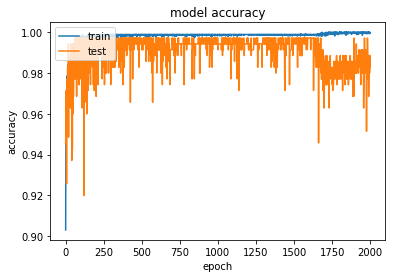

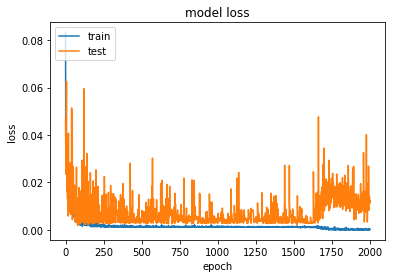

In [11]:
# Now, fit the model to the data
history = model.fit(x, y, validation_data=(x_dev, y_dev), epochs=2000, batch_size=32)

# List all data in history
print(history.history.keys())
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Load pretrained conv model

In [9]:
# load json and create model
json_file = open('trained/conv_model_quickngood.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model = model_from_json(conv_model_json)
# load weights into new model
model.load_weights("trained/conv_model_quickngood.h5")
print("Loaded model from disk")

Loaded model from disk


##### Additional model evaluation

In [19]:
# This dataset was hand-labeled
x_test, y_test = utils.load_dataset(im_dir="dev_log")

In [23]:
x_val, y_val = x_dev, y_dev
# Evaluate model, get metrics back
stats = model.evaluate(x_val, y_val)
# Calculate predictions vector from model
predictions = model.predict(x_val)
predictions = np.floor(predictions + 0.5)

# Get vector mask for good and bad fits and right and wrong answers
good_fits = y_val
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on VALIDATION set")
print(".............................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
for i in range(m_dev):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print(".............................")
print("List of indices of wrong guesses:")
print(bad_list)

350/350 [==============================] - 1s 3ms/step

Performance on VALIDATION set
.............................
Loss: 0.11709877678326198
Accuracy: 0.862857141154153
Precision: 0.8676470588235294
Recall: 0.6020408163265306
.............................
List of indices of wrong guesses:
[0, 1, 16, 51, 56, 58, 61, 65, 66, 68, 73, 75, 78, 79, 81, 85, 86, 87, 116, 151, 159, 162, 172, 177, 191, 192, 196, 198, 199, 200, 201, 207, 216, 225, 230, 249, 250, 258, 275, 279, 282, 304, 307, 329, 332, 341, 343, 344]


##### Look at an image

label: [1]
prediction: [0.]
(236, 348, 3)


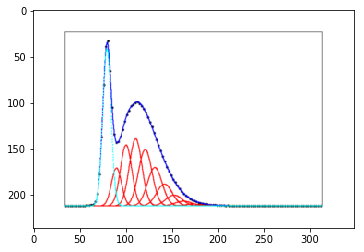

In [28]:
# Choose an index 
index = 58

# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = x[index]
print(str(this_image.shape))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

##### Save convolutional model to disc

In [12]:
#plot_model(simple_model, to_file='simple_model.png')
#SVG(model_to_dot(simple_model).create(prog='dot', format='svg'))

# serialize model to JSON
model_json = model.to_json()
with open("trained/conv_model_quickngood_2000epoch_sql_log.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("trained/conv_model_quickngood_2000epoch_sql_log.h5")
print("Saved model to disk")

Saved model to disk
